<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [4]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [5]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** думаю, что при меньших батчах обучение по скорости не сильно меняется (хотя, разумеется, зависит от признакового пространства. при большом количестве признаков меньшие батчи все же побыстрее, наверно), а вот качество ухудшается, так как модель получается менее генерализованная, и скорее всего, будет переобучаться на каждом батче

Посмотрим на какую-нибудь картинку:

Text(0.5, 1.0, 'Class is 8')

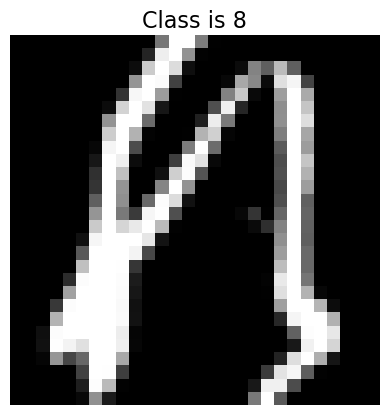

In [6]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16)

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





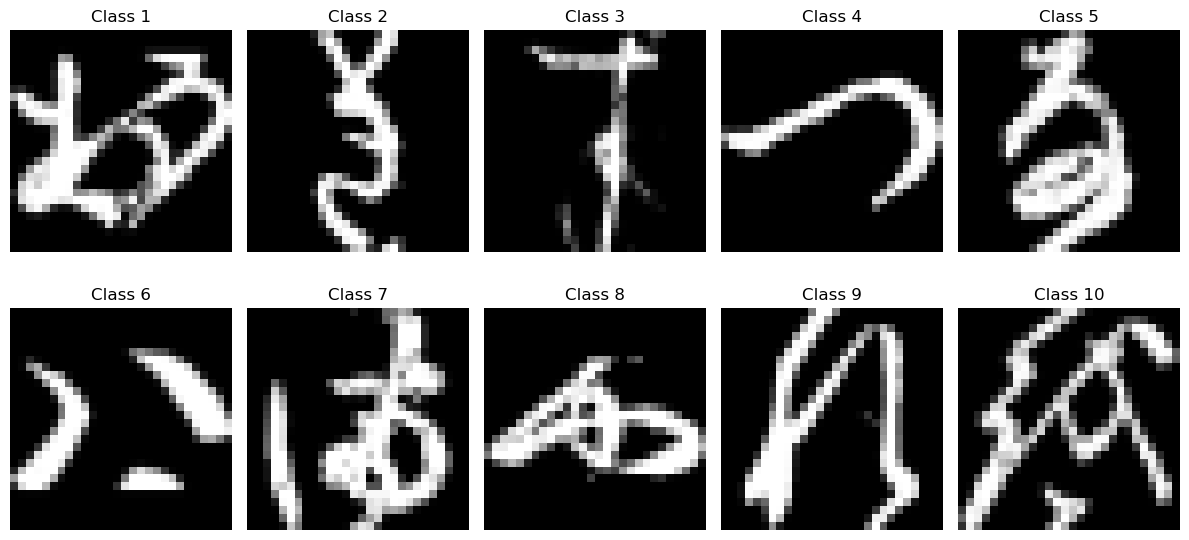

In [8]:
images_per_class = [[] for img in range(10)]

for image, label in trainset:
    if len(images_per_class[label]) < 1:
        images_per_class[label] = image.view(28, 28).numpy()

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images_per_class[i], cmap="gray")
    plt.title(f"Class {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [10]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size1,
                 hidden_size2,
                 num_classes,
                 activation=nn.ReLU()):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.activation = activation


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x
    


Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** сумма кол-ва весов и смещений каждого слоя. 
- для первого слоя: размер входного изображения (28*28) * веса для каждого признака (256), 256 смещение
- для второго слоя: размер входа = выход предыдущего слоя (256) * веса для каждого нового признака (128), 128 смещение
- для третьего слоя: размер входа = выход предыдущего слоя (128) * кол-во классов (10), 10 смещение

всего получается 234_752 весов на всех слоях и смещений 394 

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [11]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [15]:
# Создадим объект модели
fc_net = FCNet(input_size=28 * 28,
               hidden_size1=256,
               hidden_size2=128,
               num_classes=10)
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [16]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # выводим каждые 100 шагов
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

[1,   100] loss: 1.359
[1,   200] loss: 0.611
[2,   100] loss: 0.472
[2,   200] loss: 0.428
[3,   100] loss: 0.367
[3,   200] loss: 0.342
[4,   100] loss: 0.306
[4,   200] loss: 0.282
[5,   100] loss: 0.258
[5,   200] loss: 0.249
[6,   100] loss: 0.222
[6,   200] loss: 0.215
[7,   100] loss: 0.190
[7,   200] loss: 0.190
[8,   100] loss: 0.168
[8,   200] loss: 0.167
[9,   100] loss: 0.147
[9,   200] loss: 0.148
[10,   100] loss: 0.131
[10,   200] loss: 0.129


In [17]:
get_accuracy(fc_net, testloader)

0.8798

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [21]:
train_data = trainset.data.numpy()

mean = np.mean(train_data / 255)
std = np.std(train_data / 255)
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

0.1917621473589439 0.34834283034636876


In [22]:
fc_net = FCNet(input_size=28 * 28,
               hidden_size1=256,
               hidden_size2=128,
               num_classes=10)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [23]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # выводим каждые 100 шагов
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


[1,   100] loss: 1.028
[1,   200] loss: 0.454
[2,   100] loss: 0.318
[2,   200] loss: 0.283
[3,   100] loss: 0.226
[3,   200] loss: 0.215
[4,   100] loss: 0.176
[4,   200] loss: 0.167
[5,   100] loss: 0.137
[5,   200] loss: 0.136
[6,   100] loss: 0.110
[6,   200] loss: 0.113
[7,   100] loss: 0.089
[7,   200] loss: 0.092
[8,   100] loss: 0.071
[8,   200] loss: 0.076
[9,   100] loss: 0.060
[9,   200] loss: 0.060
[10,   100] loss: 0.047
[10,   200] loss: 0.048


In [24]:
get_accuracy(fc_net, testloader)

0.9015

Как изменилась `accuracy` после нормализации?

0.902 после против 0.880 до

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [25]:
activation_functions = {
    "Sigmoid": torch.nn.functional.sigmoid,
    "GELU": torch.nn.functional.gelu,
    "Tanh": torch.tanh
}

models = {}
for activation_name, activation_func in activation_functions.items():
    models[activation_name] = FCNet(input_size=28 * 28,
                                    hidden_size1=256,
                                    hidden_size2=128,
                                    num_classes=10,
                                    activation=activation_func)


In [27]:
n_epochs = 10
loss_history = []

for activation_name, model in models.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"{activation_name} Model: Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss / len(trainloader)}")

Sigmoid Model: Epoch [1/10], Loss: 1.55224301891124
Sigmoid Model: Epoch [2/10], Loss: 0.7626016946549111
Sigmoid Model: Epoch [3/10], Loss: 0.5504590483421975
Sigmoid Model: Epoch [4/10], Loss: 0.44744288502855506
Sigmoid Model: Epoch [5/10], Loss: 0.3781401017878918
Sigmoid Model: Epoch [6/10], Loss: 0.32442952927122726
Sigmoid Model: Epoch [7/10], Loss: 0.2806415488745304
Sigmoid Model: Epoch [8/10], Loss: 0.24580817254299814
Sigmoid Model: Epoch [9/10], Loss: 0.21682140123336874
Sigmoid Model: Epoch [10/10], Loss: 0.19156619031378563
GELU Model: Epoch [1/10], Loss: 0.6642711070623804
GELU Model: Epoch [2/10], Loss: 0.28698458988615805
GELU Model: Epoch [3/10], Loss: 0.20523868469481774
GELU Model: Epoch [4/10], Loss: 0.15740403999039468
GELU Model: Epoch [5/10], Loss: 0.12313371874550555
GELU Model: Epoch [6/10], Loss: 0.09890009924927924
GELU Model: Epoch [7/10], Loss: 0.0804829200214528
GELU Model: Epoch [8/10], Loss: 0.06391569238869434
GELU Model: Epoch [9/10], Loss: 0.05198823

In [28]:
for activation_name, model in models.items():
    test_accuracy = get_accuracy(model, testloader)
    print(f"{activation_name} Model Accuracy on Test Data: {test_accuracy}")


Sigmoid Model Accuracy on Test Data: 0.8553
GELU Model Accuracy on Test Data: 0.9039
Tanh Model Accuracy on Test Data: 0.8936


С использованием какой функции активации удалось досчить наибольшей `accuracy`?
 

GELU

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [34]:
models_optimizers = {
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop,
    "Adagrad": torch.optim.Adagrad
}

models = {}
for optimizer_name, optimizer_class in models_optimizers.items():
    models[optimizer_name] = FCNet(input_size=28 * 28,
                                    hidden_size1=256,
                                    hidden_size2=128,
                                    num_classes=10,
                                    activation=torch.nn.functional.gelu)

In [37]:
for optimizer_name, model in models.items():
    optimizer = optimizer_class(model.parameters(), lr=3e-4)
    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"{activation_name} Model: Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss / len(trainloader)}")

Tanh Model: Epoch [1/10], Loss: 1.3708315128975725
Tanh Model: Epoch [2/10], Loss: 0.8300141357361002
Tanh Model: Epoch [3/10], Loss: 0.6960219748476718
Tanh Model: Epoch [4/10], Loss: 0.6289115751043279
Tanh Model: Epoch [5/10], Loss: 0.5867790700273311
Tanh Model: Epoch [6/10], Loss: 0.5568451188980265
Tanh Model: Epoch [7/10], Loss: 0.5338564181581457
Tanh Model: Epoch [8/10], Loss: 0.514601432262583
Tanh Model: Epoch [9/10], Loss: 0.4993644214691
Tanh Model: Epoch [10/10], Loss: 0.48623900755922844
Tanh Model: Epoch [1/10], Loss: 1.348146902246678
Tanh Model: Epoch [2/10], Loss: 0.8085333220502163
Tanh Model: Epoch [3/10], Loss: 0.6869509658914932
Tanh Model: Epoch [4/10], Loss: 0.6255002021789551
Tanh Model: Epoch [5/10], Loss: 0.5859790684060847
Tanh Model: Epoch [6/10], Loss: 0.5576937060406868
Tanh Model: Epoch [7/10], Loss: 0.5356179186638366
Tanh Model: Epoch [8/10], Loss: 0.5175240809613085
Tanh Model: Epoch [9/10], Loss: 0.501919689711104
Tanh Model: Epoch [10/10], Loss: 0.

In [38]:
for optimizer_name, model in models.items():
    test_accuracy = get_accuracy(model, testloader)
    print(f"{optimizer_name} Optimizer Accuracy on Test Data: {test_accuracy}")

Adam Optimizer Accuracy on Test Data: 0.7266
RMSprop Optimizer Accuracy on Test Data: 0.7229
Adagrad Optimizer Accuracy on Test Data: 0.7251


Есть подозрение, что я сделал что-то не так, ибо Адам уже использовался изначально, а аккураси упала (вообще другая, причем достаточно сильно)

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [39]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.max(x, torch.tensor(0.0))


Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [40]:
model_with_custom_relu = FCNet(input_size=28 * 28,
                               hidden_size1=256,
                               hidden_size2=128,
                               num_classes=10,
                               activation=CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model_with_custom_relu.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model_with_custom_relu(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"CustomReLu Model: Epoch [{epoch + 1}/{n_epochs}], Loss: {running_loss / len(trainloader)}")



CustomReLu Model: Epoch [1/10], Loss: 0.6956274160679351
CustomReLu Model: Epoch [2/10], Loss: 0.3092076695345818
CustomReLu Model: Epoch [3/10], Loss: 0.22870569736399549
CustomReLu Model: Epoch [4/10], Loss: 0.17896197295569358
CustomReLu Model: Epoch [5/10], Loss: 0.14400240766241196
CustomReLu Model: Epoch [6/10], Loss: 0.11689587246547355
CustomReLu Model: Epoch [7/10], Loss: 0.09701061719592581
CustomReLu Model: Epoch [8/10], Loss: 0.07894194557311687
CustomReLu Model: Epoch [9/10], Loss: 0.06432124538783063
CustomReLu Model: Epoch [10/10], Loss: 0.05256644182224223


In [41]:
get_accuracy(model_with_custom_relu, testloader)

0.9003

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.